# Modelo para la predicción de pedidos de taxi para la proxima hora



La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

# Librerías

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

#Preparación de los datos

Primeramente importamos el Data Frame, en este caso, al tratarse de un proyecto de series temporales, se procede a colocar las fechas como el índice, ordenarlas y convertilas a tipo datetime[64]

Luego se procede a ordenar dichos índices por fecha

In [ ]:
try:
  taxis = pd.read_csv('/content/drive/MyDrive/practicum/Sprint13/taxi.csv',index_col=[0], parse_dates=[0])
  taxis.sort_index(inplace = True)

except:
  taxis = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
  taxis.sort_index(inplace = True)

Se observa el inicio del data Frame para saber en que fecha comienza el estudio

In [ ]:
taxis.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Observamos el final de Data frame para determinar cuando termina el estudio

In [ ]:
taxis.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


El periodo de estudio es desde el 01/03/2018 al 31/08/2018 es decir 6 meses de datos, suficiente para realizar una predicción fidedigna

Observamos si existen valor nulos en nuestra serie

In [ ]:
taxis.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Al ver que no, se realiza el describe para poder terner mas información sobre como se distribuyen los datos

In [ ]:
taxis.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


## Conclusión intermedia

Se evidencia que los datos pudieron ser ordenados con éxito, se puedo pasar al tipo datetime[64] haciendo más sencilla la tarea del análisis de la serie temporal.

Se observa un dataframe ocmpleto son valores nulos.

Se evidencia una desviación estandar de 9 ordenes de viaje, con una data de más de 26.000 entradas, vemos que lo más común es tener un aproximado de entre 8 y 19  ordenes de taxi cada 10 min.

Observamos que hay moemntos donde no se tiene pedidos, y otros donde le máximo fue de 119 ordenes en 10min.

La media de viajes cada 10min en una jornada es de 14.

#Análisis de los datos

Se procede a relaizar un análisis de la serie temporal

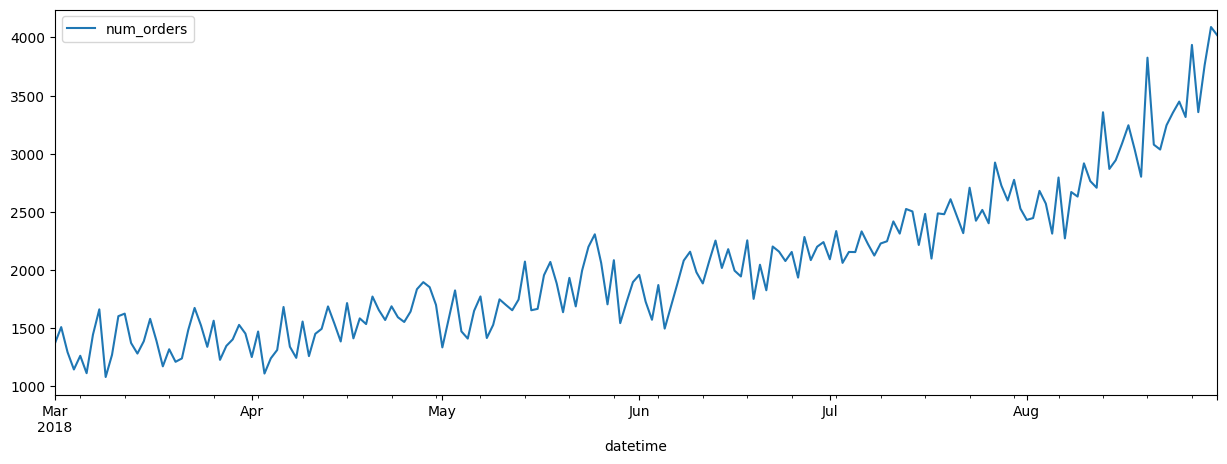

In [ ]:
taxis.resample('1D').sum() .plot(figsize = (15,5))
plt.show()

Como se observa, se evidencia una clara tendencia a la alza, con un mayor incremento a partir del mes de Julio (se puede deber a que es temporada de verano y los turistas aumentan en etsas temporadas)

Para estudir más a fondo las características, se procede a segmentar la serie en sus 3 componentes, tendencia, estacionalidad y residuales

Text(0.5, 1.0, 'Residuales')

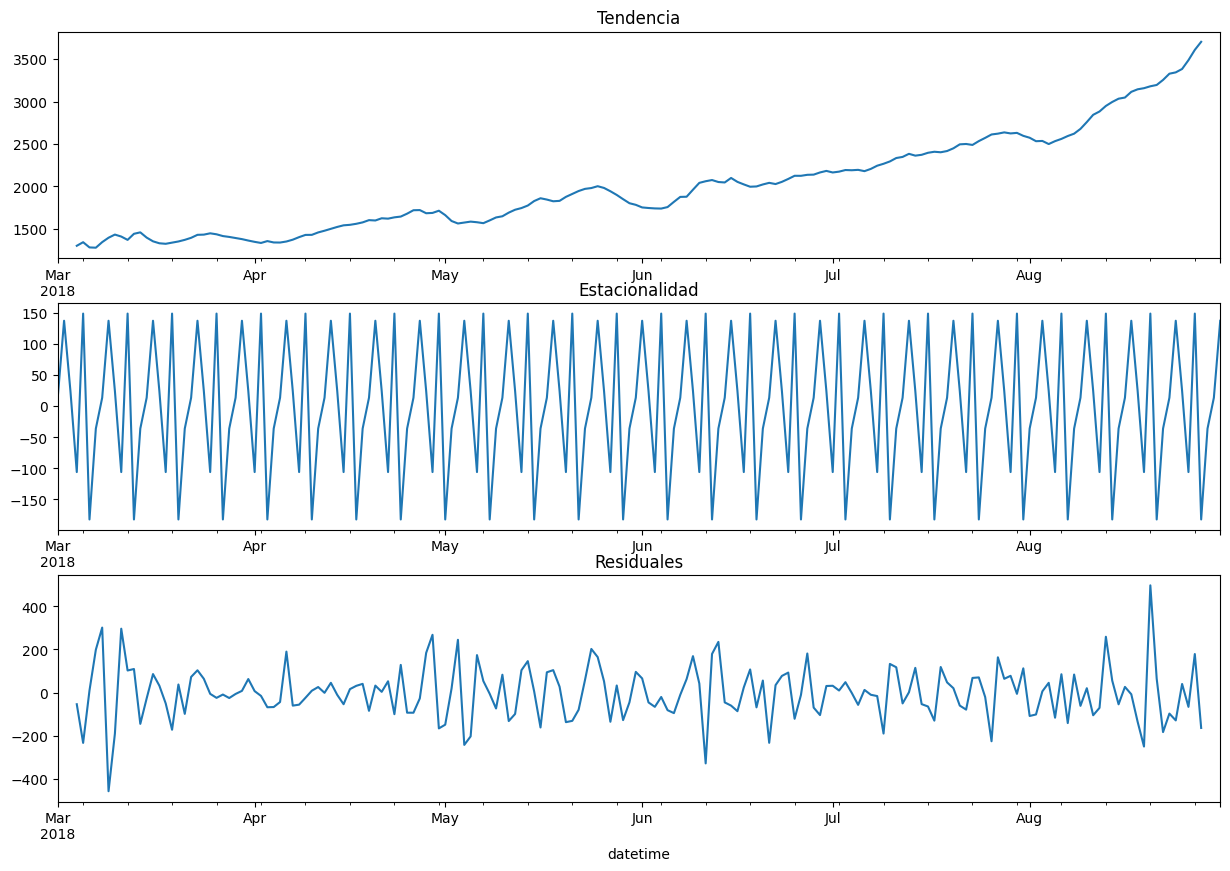

In [ ]:
data = taxis.resample('1D').sum() 
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15, 10)) 
plt.subplot(311) 

decomposed.trend.plot(ax=plt.gca()) 
plt.title('Tendencia') 
plt.subplot(312) 

decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Estacionalidad') 
plt.subplot(313) 
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuales')

En este caso, se evidencia calramente una tendencia a la alza con aumento en su pendiente a partir de junio.

Se evidencia que es una serie de tiempo estocástica no estacionaria, ya que el valor medio cambia con el tiempo.


A continuación, se procede a subdividir los datos por hora, para así poder predecir cuantos serán los viajes para la proxima hora, y de esta manera poder anticiparnos y detemrianr la demanda que se nos presenta.

In [ ]:
data_hours = taxis.resample('1H').sum() 

<Axes: xlabel='datetime'>

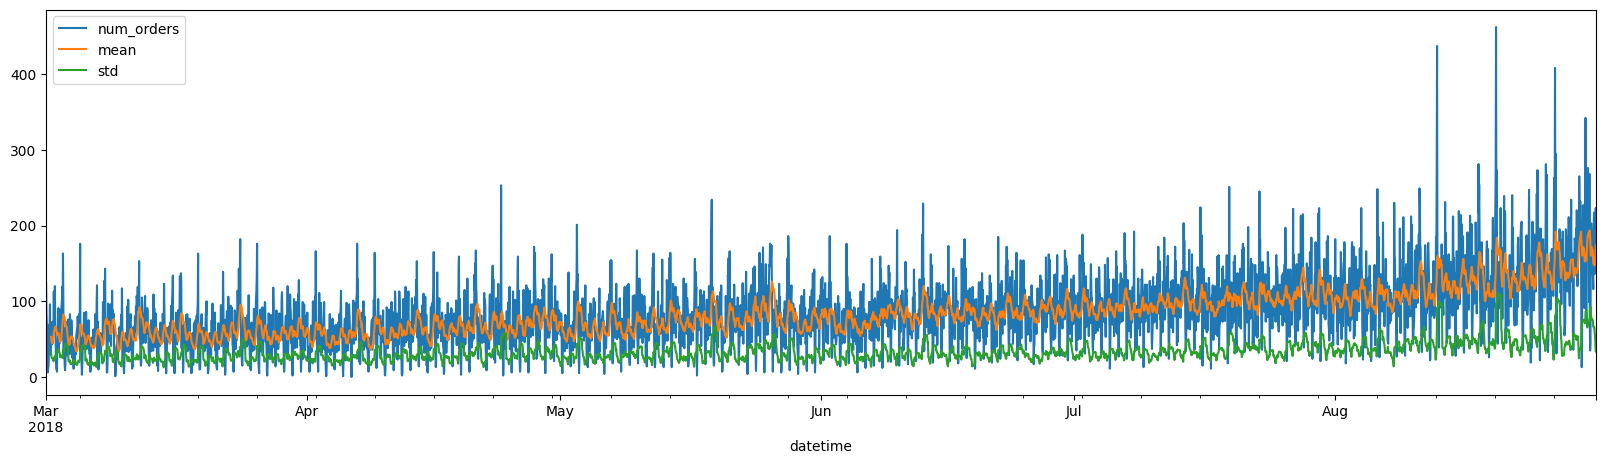

In [ ]:
data_hours['mean'] = data_hours['num_orders'].rolling(15).mean() 
data_hours['std'] = data_hours['num_orders'].rolling(15).std() 
data_hours.plot(figsize=(20, 5)) 

En este gráfico se puede evidenciar como se distribuye la media y la desviación estandar de los datos.

No se muestra demasiada desviación estandar, lo que es bueno, ya que de esta manera la predicción será más sencilla

A continuación, se realiza un análisis de los 3 últimos meses de la sitribución para ver el comportamiento y que días fueron los que más trabajo se tuvo

<ipython-input-148-60042f012e49>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data2 = taxis['2018-06'].resample('1H').sum()
<ipython-input-148-60042f012e49>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data3 = taxis['2018-07'].resample('1H').sum()
<ipython-input-148-60042f012e49>:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data4 = taxis['2018-08'].resample('1H').sum()


Text(0.5, 1.0, 'Agosto')

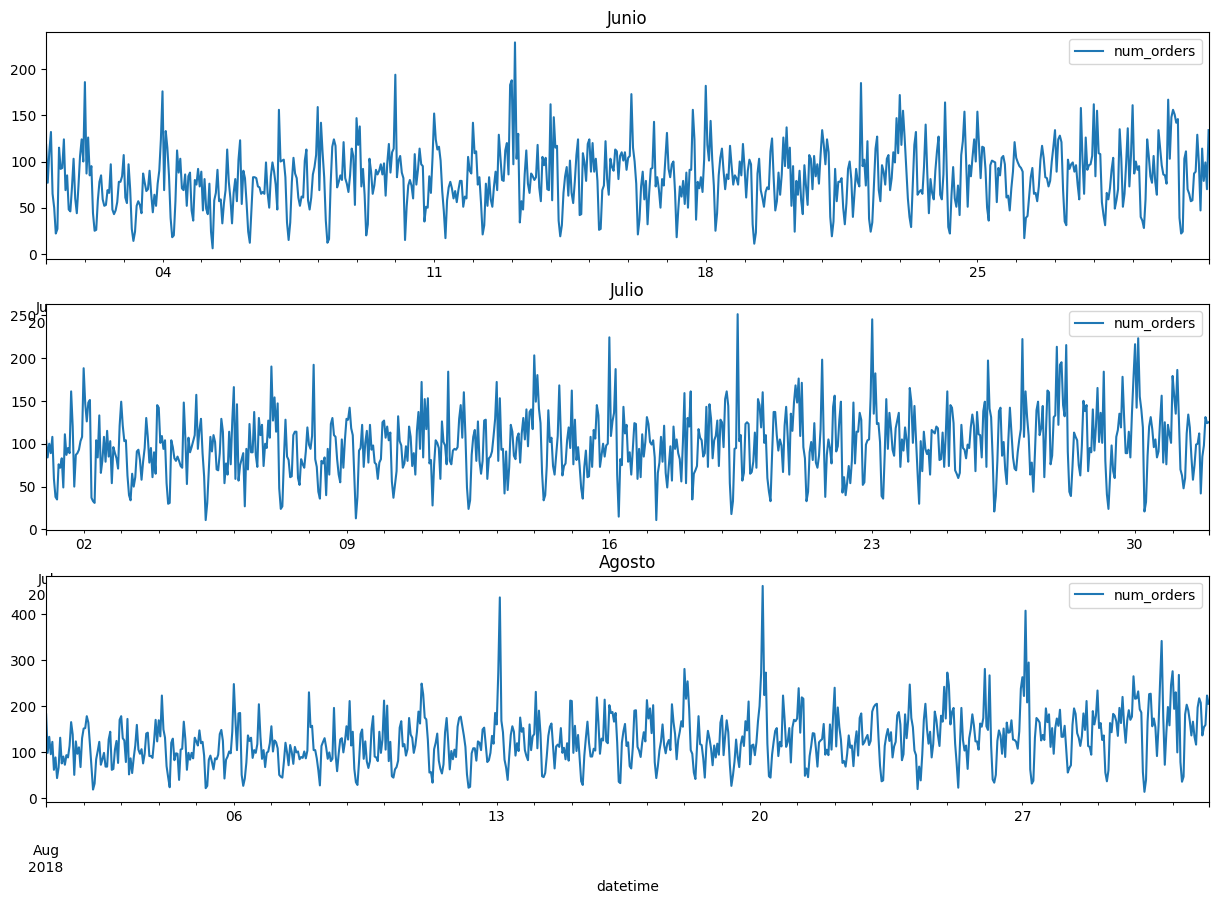

In [ ]:
data2 = taxis['2018-06'].resample('1H').sum() 
data3 = taxis['2018-07'].resample('1H').sum() 
data4 = taxis['2018-08'].resample('1H').sum() 


plt.figure(figsize=(15, 10)) 
plt.subplot(311) 

data2.plot(ax=plt.gca()) 
plt.title('Junio') 
plt.subplot(312) 

data3.plot(ax=plt.gca()) 
plt.title('Julio') 
plt.subplot(313) 

data4.plot(ax=plt.gca()) 
plt.title('Agosto')



En agosto se pueden observar 2 picos muy claros el 13, el 20 y el 27, seguramente esos días hubo algún evento en la ciudad, sin embargo los otros días meses meses se muetsran más parejos y todos muestran una tendencia estocastica estacionaria. Es decir que nedro de los meses se podria decir que Un proceso estocástico es estacionario, sin embargo en el tiempo va con tendencia a la alza, lo cual nos conviene, ya que significa mayores ventas y que la empresa está crecinedo.

Si como prueba descomponemos el mejor més, es decir agosto para detemiar si existe algúna característica que nos hizo mejores dicho día:

Text(0.5, 1.0, 'Residuales')

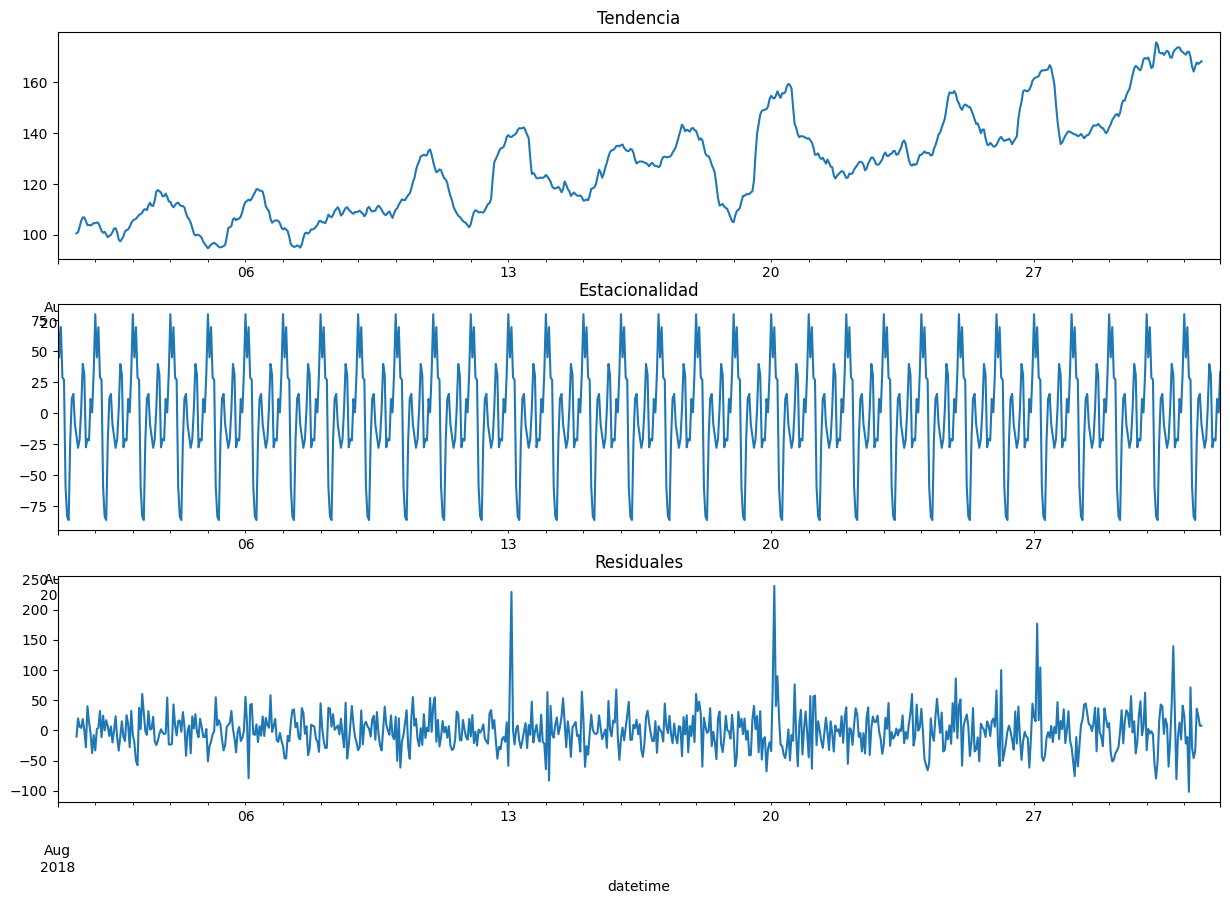

In [ ]:

decomposed = seasonal_decompose(data4)

plt.figure(figsize=(15, 10)) 
plt.subplot(311) 

decomposed.trend.plot(ax=plt.gca()) 
plt.title('Tendencia') 
plt.subplot(312) 

decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Estacionalidad') 
plt.subplot(313) 
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuales')


Se observa una tendencia algomenos a la alza, una distribución más estacionaria y los picos de los que se habló anteriormente

## Conclusión intermedia

Se observa un calro aumento en la pendiente de la recta que describe el número de ordenes en el tiempo a partir del més de junio,  lo cual puede indicar que al llegar la época de verano aumenta el empleo de taxis como medio de transporte, siendo esta una muy buena oportunidad para potenciación de las ventas para la empresa

Así mismo, se evidnecia presencia de picos en agosto, en los días 13, 20 y 27, claramente diferencaidos del resto, se recomienda estudiar que sucedió dichos días, para detemrinar futuras oportunidades de negocio, y potencias capañas de marketing dichos días.

Se evidencia una clara y marcada tendencia a la alza a lo largo de todo el periodo de estudio, indicando que todo va en excelente camino.


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
Buen trabajo con esta exploración de los datos.
</div>

# Formación del modelo

Se procede a armar y probar los modelos

Primeramente se crea una función que nos permita crear características para un horizonte de pronóstico. Ya que de esta manera se puede evitar que  las tendencias y la estacionalidad se vinculen con una fecha específica, y de esta manera el modelo seá más confiable.

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )



Se procede a separar los datos en conjuntos de entrenamiento, validación y prueba

In [ ]:

make_features(data_hours, 9, 15)

train, valid = train_test_split(data_hours, shuffle=False, test_size=0.3)
train = train.dropna()

train = train.reset_index(drop = True)
valid = valid.reset_index(drop = True)

X_train = train.drop('num_orders', axis = 1).reset_index(drop = True)
y_train = train['num_orders'].reset_index(drop = True)

X_valid = valid.drop('num_orders', axis = 1).reset_index(drop = True)
y_valid = valid['num_orders'].reset_index(drop = True)


Primeramente se realiza la prueba con un modelo de regresión lienal simple

In [ ]:
model = LinearRegression()
model.fit(X_train , y_train)

pred_previous_train_lr = model.predict(X_train)
pred_previous_valid_lr = model.predict(X_valid)

print("RMSE para el conjunto de entrenamiento:", round(mean_squared_error(pred_previous_train_lr, y_train)**(0.5),2), '%')
print("RMSE para el conjunto de validación:", round(mean_squared_error(pred_previous_valid_lr, y_valid)**(0.5),2), '%')


RMSE para el conjunto de entrenamiento: 18.25 %
RMSE para el conjunto de validación: 31.03 %


Con cada conjunto se obtuvieron muy buenos valores, con una raíz del error caudrático medio menor del 18.25 % para el conjunto de entrenamiento y del 31.03 % para el de validación, valores muy buenos de predicción, bastante fiables

Ahora bien empleando un modelo de bosque a leatorio de decisión

In [ ]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_valid)
print(f' RMSE = {round(mean_squared_error(y_valid, pred, squared=False),2)} %' )

 RMSE = 40.27 %


Observamos que el RMSE obtenido de es de 40.27 %, aplicando un algoritmo de validación cruzada tenemos que:

In [ ]:
# defining parameter range 
param_grid = {'n_estimators':[155],
              'max_depth': [None,3,6,9],
              'min_samples_split':[2,4,6,8],
              'random_state':[42,567,12345]}  
   
grid_RFR = GridSearchCV(RandomForestRegressor(), param_grid, refit = True, verbose = 10, n_jobs=-1, scoring = 'neg_root_mean_squared_error') 
   
# fitting the model for grid search 
grid_RFR.fit(X_train, y_train) 
 
# print best parameter after tuning 
print(grid_RFR.best_params_) 
grid_predictions_RFR = grid_RFR.predict(X_valid) 
   
# print classification report 
print(f'RMSE = {round(mean_squared_error(y_valid, grid_predictions_RFR, squared=False),2)} %') 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 153, 'random_state': 12345}
RMSE = 39.71 %


El RMSE obtenido para este caso de un poco menor, siendo del 39.7%, mejorando solo un poco el porcentaje

Luego se pruba un modelo de arbol de desición regresor

In [ ]:
model = DecisionTreeRegressor( random_state= 42)
model.fit(X_train, y_train)
pred = model.predict(X_valid)
print(f' RMSE = {round(mean_squared_error(y_valid, pred, squared=False),2)} %' )

 RMSE = 47.17 %


Modificando hiperparámetros

In [ ]:
# defining parameter range 
param_grid = {'min_samples_split':[2,5,8,10,15,16],
              'max_depth': [None,2,4,6,7,8],
              'min_samples_leaf':[1,5,10],
              'random_state':[42]}  
   
grid_DTR = GridSearchCV(DecisionTreeRegressor(), param_grid, refit = True, n_jobs=-1, cv= kf, scoring = 'neg_root_mean_squared_error') 
   
# fitting the model for grid search 
grid_DTR.fit(X_train, y_train) 
 
# print best parameter after tuning 
print(grid_DTR.best_params_) 
grid_predictions_DTR = grid_DTR.predict(X_valid) 
   
# print classification report 
print(f' RMSE = {round(mean_squared_error(grid_predictions_DTR, y_valid, squared=False),2)} %') 

{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 16, 'random_state': 42}
 RMSE = 46.32 %


El mejor modelo arrojó un 46.32 % lo cual es un excelente resultado  sin embargo superior a los otros

Realizando el mismo procedieminto empleando `GridSearchCV`

Por último se utiliza un algoritmo de potenciación de gradiente con 10 iteraciones por medio de la librería CatBoost

In [ ]:
model_CAT = CatBoostRegressor(iterations = 150 ,  loss_function='RMSE')
model_CAT.fit(X_train,y_train, verbose=10 )
predict_CAT = model_CAT.predict(X_valid)
RMSE = mean_squared_error(y_valid,predict_CAT )**(1/2)

        
print(f'The best RMSE = {round(RMSE,2)} %')

Learning rate set to 0.228623
0:	learn: 30.5958619	total: 4.88ms	remaining: 727ms
10:	learn: 20.2915142	total: 43.4ms	remaining: 548ms
20:	learn: 18.2898126	total: 99.6ms	remaining: 612ms
30:	learn: 16.9082810	total: 139ms	remaining: 533ms
40:	learn: 15.7828917	total: 173ms	remaining: 459ms
50:	learn: 14.5648597	total: 216ms	remaining: 420ms
60:	learn: 13.6001087	total: 251ms	remaining: 366ms
70:	learn: 12.9209178	total: 291ms	remaining: 323ms
80:	learn: 12.2442679	total: 323ms	remaining: 276ms
90:	learn: 11.6417744	total: 364ms	remaining: 236ms
100:	learn: 11.1478030	total: 401ms	remaining: 195ms
110:	learn: 10.7054812	total: 437ms	remaining: 154ms
120:	learn: 10.2994440	total: 471ms	remaining: 113ms
130:	learn: 9.9141977	total: 505ms	remaining: 73.3ms
140:	learn: 9.5273825	total: 537ms	remaining: 34.3ms
149:	learn: 9.2841208	total: 567ms	remaining: 0us
The best RMSE = 42.46 %


Como se evidencia el mejor valor obtenido es del 42.46% dejando bastante que desear

Por último se decide emplear otro algoritmo de est tipo, empleando una validación cruzada por medio de la librería XGBoost

In [ ]:
# defining parameter range 
param_grid = {'n_stimators':[100, 150,200,300],
              'max_depth': [None, 3,6,9],
              'gamma':[0.01,0.1],
              'learning_rate': [0.001, 0.01, 0.1, 1]}  
   
grid_XGB = GridSearchCV(XGBRegressor(), param_grid, n_jobs=-1, cv= kf, scoring = 'neg_root_mean_squared_error', refit = True) 
   
# fitting the model for grid search 
grid_XGB.fit(X_train, y_train) 
 
# print best parameter after tuning 
print(grid_XGB.best_params_) 
grid_predictions_XGB = grid_XGB.predict(X_valid) 
   
# print classification report 
print(f'RMSE = {round(mean_squared_error(grid_predictions_XGB, y_valid)**0.5,2)} %') 

[16:27:33] WARNING: ../src/learner.cc:767: 
Parameters: { "n_stimators" } are not used.

{'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': None, 'n_stimators': 100}
44.01334816859377


Como vemos el valor se mantiene similar a los anteriores, en 44.01 %

## Conclusión intermedia

Como podemos observar, el modelo de regresión lineal es el que ha arrojado los mejores resultados, habiendo conseguido hasta un 31.03% de error.

El resto de modelos fueron inferiores, sin embargo se procede a realizar las comprobaciones finales por medio de los conjuntos de prueba para cada modelo.

Para comparar los modelos y resultados se tiene la siguiente tabla

In [ ]:
results = {'model': ['Linear_regression','RandomForestRegressor','DecisionTreeRegressor','model_CAT','XGBRegressor'],
           'RMSE (%)': [round(mean_squared_error(pred_previous_valid_lr, y_valid)**(0.5),2),
                   round(mean_squared_error(y_valid, grid_predictions_RFR, squared=False),2),
                   round(mean_squared_error(grid_predictions_DTR, y_valid, squared=False),2),
                   round(RMSE,2),
                   round(mean_squared_error(grid_predictions_XGB, y_valid)**0.5,2)]}


                      

In [ ]:
results = pd.DataFrame(data = results)

In [ ]:
results

,model,RMSE (%)
0,Linear_regression,31.03
1,RandomForestRegressor,39.71
2,DecisionTreeRegressor,46.32
3,model_CAT,42.46
4,XGBRegressor,44.01


Como se observa, el modelo de regresión lineal es el que mejor resltados arroja, siguiendole el RandomForestRegressor y siendo el peor el DecisionTreeRegressor

# Conclusión general 

Se evidencia que los datos pudieron ser ordenados con éxito, se puedo pasar al tipo datetime[64] haciendo más sencilla la tarea del análisis de la serie temporal.

Se observa un dataframe ocmpleto son valores nulos.

Se evidencia una desviación estandar de 9 ordenes de viaje, con una data de más de 26.000 entradas, vemos que lo más común es tener un aproximado de entre 8 y 19  ordenes de taxi cada 10 min.

Observamos que hay moemntos donde no se tiene pedidos, y otros donde le máximo fue de 119 ordenes en 10min.

La media de viajes cada 10min en una jornada es de 14.

Se observa un calro aumento en la pendiente de la recta que describe el número de ordenes en el tiempo a partir del més de junio,  lo cual puede indicar que al llegar la época de verano aumenta el empleo de taxis como medio de transporte, siendo esta una muy buena oportunidad para potenciación de las ventas para la empresa

Así mismo, se evidnecia presencia de picos en agosto, en los días 13, 20 y 27, claramente diferencaidos del resto, se recomienda estudiar que sucedió dichos días, para detemrinar futuras oportunidades de negocio, y potencias capañas de marketing dichos días.

Se evidencia una clara y marcada tendencia a la alza a lo largo de todo el periodo de estudio, indicando que todo va en excelente camino.

Se implementaron 3 modelos, Regresión lineal, arbol de desició aleatorio y Potenciación de gradiente.

Como era de esperarse, el modelo que mejor dió resultado fué la regresión lineal con un RMSE = 31.03% superando en 17.23% las expectativas del cliente, el cual requeria de un medelo de máximo RMSE = 48% 
